In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import multiprocess
import warnings

import geopandas as gpd
from glob import glob
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

/tmp/ipykernel_2983008/1199462475.py:5: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [3]:
def read_POUS(filepath: str) -> pd.DataFrame:
    """
    Read poweroutage.us CSV data from disk.
    
    Args:
        filepath: Path to CSV file
    """
    
    # read in data (note the unusual encoding)
    # read in county ID codes as strings to prevent dropping of leading 0 
    raw = pd.read_csv(
        outage_path,
        encoding="utf-16",
        dtype={
            "CountyFIPS": str,
            "CustomersTracked": np.int32,
            "CustomersOut": np.int32,
        }
    )

    # generate a DateTimeIndex
    clean = raw.set_index(pd.to_datetime(raw.RecordDateTime))
    clean = clean.drop(columns=["RecordDateTime"])

    # drop rows without county codes (empty string in CSV -> NaN in dataframe)
    clean = clean[~clean.CountyFIPS.isna()]

    # discard utility information and groupby the hour and county
    county_hour = clean.groupby([clean.index, clean.CountyFIPS]).sum(numeric_only=True)
    
    return county_hour

In [4]:
def merge_in_geometry(county_hour: pd.DataFrame, counties: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Combine the outage timeseries data with county border polygons. Calculates outage fraction.
    
    Args:
        county_hour: Timeseries data containing `CountyFIPS` column to join on, along with
            `RecordDateTime`, `CustomersOut` and `CustomersTracked`.
        counties: Geographic data containing `STATEFP`, `geometry` and `GEOID`.
    """
    
    # merge in county boundary polygons
    long_format = county_hour.reset_index()
    outage_geography = (
        long_format.merge(
            counties[["STATEFP", "GEOID", "geometry"]],
            left_on="CountyFIPS",
            right_on="GEOID")
        .drop(columns=["GEOID"])
    )
    # recreate our DateTimeIndex
    outage = (
        outage_geography.set_index(
            pd.to_datetime(outage_geography.RecordDateTime)
        ).drop(columns=["RecordDateTime"])
    )
    outage = gpd.GeoDataFrame(outage)
    # calculate an outage fraction
    outage["Fraction"] = outage.CustomersOut / outage.CustomersTracked
    
    return outage

In [5]:
def map_outage_at_time(outage_data: gpd.GeoDataFrame, timestamp: str, quantile_timeseries: dict, bbox: np.ndarray[float], plot_dir: str) -> None:
    """
    Chloropleth map `outage_data.Fraction` in between 0 and 1 for `outage_data.geometry` polygons
    at `timestamp` time. Also plot inset of whole event timeseries as inset, with current time highlighted.
    
    Args:
        outage_data: Table of `Fraction` data with a DatetimeIndex and `geometry`.
        timestamp: Timestamp we wish to map
        quantile_timeseries: Dict of quantile level -> pandas DataFrame containing at least `index` and `Fraction`
        bbox: Map bounding box; iterable of min_x, min_y, max_x, max_y
        plot_dir: Location to save map
    """
    
    filepath = os.path.join(plot_dir, timestamp.replace(" ", "_") + ".png")
    if os.path.exists(filepath):
        return

    outage_mask = outage_data.Fraction > 0.01
    outage_data.loc[~outage_mask, "Fraction"] = -1

    bounds = np.array([0, 0.05, 0.2, 0.4, 0.6, 0.8, 1])
    n_bins = len(bounds)
    cmap = plt.cm.get_cmap("inferno", n_bins + 1)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    colours = outage_data.Fraction.apply(cmap)

    f, ax = plt.subplots(figsize=(14, 9))
    ax_line = ax.inset_axes([0.1, 0.12, 0.35, 0.25])

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.1)

    outage_data.plot(
        ax=ax,
        color=colours,
        cax=cax,
    )

    ax.set_xlabel("Longitude", labelpad=15)
    ax.set_ylabel("Latitude", labelpad=15)
    ax.grid(alpha=0.2)
    ax.set_title(timestamp)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    borders = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    borders.plot(ax=ax, facecolor="none", edgecolor="grey", alpha=0.2)

    min_x, min_y, max_x, max_y = bbox
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)

    cb = matplotlib.colorbar.ColorbarBase(
        cax,
        cmap=cmap,
        norm=norm,
        spacing='proportional',
        ticks=bounds,
        boundaries=bounds,
        format='%.2f'
    )
    cax.set_ylabel("Outage fraction", labelpad=10)

    quantile_colours = {
        # less than median not visible on linear plot
        0.5: "lightcyan",
        0.75: "cyan",
        0.9: "mediumturquoise",
        0.95: "mediumseagreen",
        0.99: "olivedrab"
    }
    for quantile, timeseries in quantile_timeseries.items():
        ax_line.plot(timeseries.index, timeseries.Fraction, label=f"{quantile}", c=quantile_colours[quantile])
    ax_line.axvline(timeseries.index[timeseries.index == timestamp])
    ax_line.set_ylim(0, 1)
    ax_line.set_ylabel("Outage fraction")
    legend = ax_line.legend(prop={'size': 6}, loc="upper right")
    legend.set_title(title="Quantile", prop={'size': 8})
    ax_line.tick_params(axis='x', labelsize=8)
    ax_line.set_title("Distribution of county outage rates")
    plt.setp(ax_line.get_xticklabels(), rotation=-45, ha="left", rotation_mode="anchor")

    f.suptitle("Hurricane Irma: electricity outages by US county")

    plt.subplots_adjust(left=0.15, right=0.85, top=0.9, bottom=0.15)
    
    f.savefig(filepath)
    plt.close(f)
              
    return

In [13]:
def map_outage(outage: gpd.GeoDataFrame, start: str, stop: str, event_name: str, n_cpu: int, plot_dir: str) -> None:
    """
    Map `outage.Fraction` on `outage.geometry` from `start` to `stop`. Produces
    frames for each timestamp and animates them.
    
    Args:
        outage: Table containing outage information. Must include `geometry` and
            `Fraction`, a float between 0 and 1.
        start: Timestamp to start drawing from.
        stop: Timestamp to stop drawing at.
        event_name: Used as title and filename of frames and animation.
        n_cpu: Number of processors used to create individual frames in parallel.
        plot_dir: Where to place event subfolder containing plot files.
    """
    outage_window = outage.loc[start: stop]
    
    # compute a map window from the bbox that encompasses all features, plus a buffer 
    buffer_fraction = 0.05
    min_x, min_y, max_x, max_y = outage_window.total_bounds
    span_x = max_x - min_x
    span_y = max_y - min_y
    buffer = buffer_fraction * max([span_x, span_y])
    bbox = [min_x - buffer, min_y - buffer, max_x + buffer, max_y + buffer]
    
    # compute the timeseries once and pass in to plotter
    quantile_timeseries = {}
    for quantile in [0.5, 0.75, 0.9, 0.95, 0.99]:
        quantile_timeseries[quantile] = outage_window[["Fraction"]].groupby("RecordDateTime").quantile(quantile)

    event_dir = os.path.join(plot_dir, event_name)
    if not os.path.exists(event_dir):
        os.makedirs(event_dir)

    print(f"Making frames with {n_cpu=}...")
    args = []
    for timestamp in sorted(set(outage_window.index)):
        args.append((outage_window.loc[timestamp], str(timestamp), quantile_timeseries, bbox, event_dir))

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="The get_cmap function was deprecated")     
        with multiprocess.Pool(processes=n_cpu) as pool:
            pool.starmap(map_outage_at_time, args)

    print("Animating into .gif with imagemagick...")
    plot_paths = glob(os.path.join(event_dir, "*.png"))
    os.system(f"convert -delay 20 {' '.join(sorted(plot_paths))} {os.path.join(plot_dir, f'{event_name}.gif')}")
    
    print("Done")
    return

In [7]:
root_dir = "data"
counties_path = os.path.join(root_dir, "raw/counties/cb_2018_us_county_500k.shp")

year = 2017

csv_filename = f"raw/outage/POUS_Export_CountyByUtility_Hourly_{year}04-{year}10.csv"
outage_path = os.path.join(root_dir, csv_filename)
processed_path = os.path.join(root_dir, f"processed/outage/{year}.parquet")

if os.path.exists(processed_path):
    print(f"{processed_path} exists")
    outage = gpd.read_parquet(processed_path)

else:
    print(f"{processed_path} does not exist, creating...")
    # merge datasets and save to disk

    # read CSV records of outages
    county_hour = read_POUS(outage_path)

    # read in census bureau county data
    counties = gpd.read_file(counties_path)

    # combine the datasets by shared county ID
    outage = merge_in_geometry(county_hour, counties)

    print("Saving to disk as parquet...")
    outage.to_parquet(processed_path)

data/processed/outage/2017.parquet does not exist, creating...
Saving to disk as parquet...


<Axes: title={'center': 'US electricity outages, 2017'}, xlabel='RecordDateTime'>

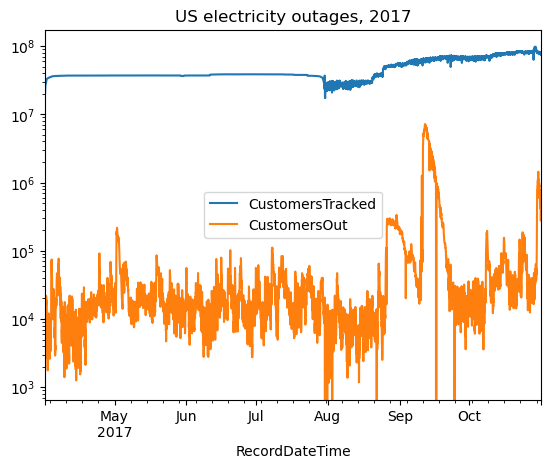

In [8]:
# sum across the counties for a country-wide picture
by_hour = outage.loc[:, ["CustomersTracked", "CustomersOut"]].groupby(level=["RecordDateTime"]).sum()
by_hour.plot(logy=True, title=f"US electricity outages, {year}")

In [9]:
# irma AOI
eastern_state_codes = {
    "01",  # AL
    "13",  # GA
    "12",  # FL
    "45",  # SC
    "47",  # TN
    "37",  # NC
    "28",  # MS
}

# filter geographically
outage_AOI = outage[outage.STATEFP.isin(eastern_state_codes)]

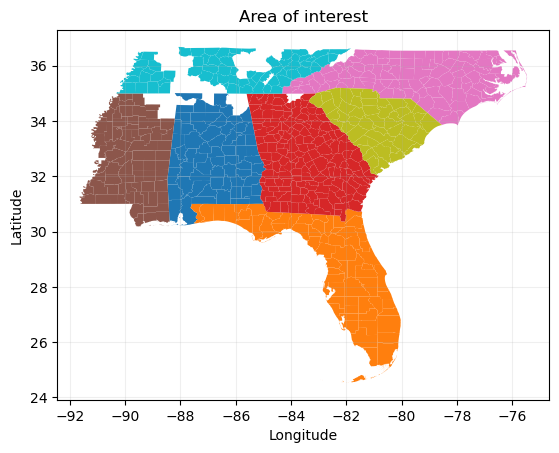

In [10]:
# counties we're analysing
ax = outage_AOI.groupby(outage_AOI.CountyFIPS).first().plot(column="STATEFP")
ax.set_title("Area of interest")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(alpha=0.2)

In [14]:
# animate Irma electricity outage
plt.style.use('dark_background')  # for cool points
map_outage(outage_AOI, "2017-09-09", "2017-09-20", "irma_2017", 60, "plots")

Making frames with n_cpu=60...
Animating into .gif with imagemagick...
Done
